In [1]:
import numpy as np
import os
import xarray as xr
from matplotlib import pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp2d
import scipy.optimize as so
import math

# 1.SWOT and nadir data

## 1.1. Import data
   path_nadir and path_SWOTpass on OSMOSIS1 domain are imported:

In [2]:
#### SWOT DATA
# Make sure to put this script in the directory below (/data/OSMOSIS/) before you run it

domain_name = 'OSMOSIS1'
addpath = '/Users/ASUS/BOOST_SWOT/data'
os.chdir(r'/Users/ASUS/BOOST_SWOT/data/OSMOSIS')

# Name of the SWOT pass in data/*domain*/ directory
if domain_name == 'OSMOSIS1' :
    path_SWOTpass = 'BOOST-SWOT_SWOT_OSMOSIS_c02_p436.nc'
    path_nadir = 'BOOST-SWOT_J1_nadir_c05_p01.nc'
    # Plotting params
    max_range = 0.2 # Limit for colorbar (SSH in meters) for SSH
    max_range_diff = 0.1 # Limit for colorbar (SSH in meters) for SSH differences

## 1.2. Download
Then SWOT and Nadir paths are downloaded

In [3]:
#### Download the SWOT path

roll_error_only = True

all_but_karin = False

with xr.open_dataset(path_SWOTpass, mask_and_scale=True) as (ds_SWOTpass):
    ntime = ds_SWOTpass.time.size
#ds_SWOTpass.info() # Dimension of the dataset
    nc = ds_SWOTpass.nC.size
    lon_swotpass = np.zeros([ntime, nc])
    lon_swotpass [:,:] = ds_SWOTpass.lon
    lon_swotpass = np.ma.masked_invalid(lon_swotpass)
    lat_swotpass = np.zeros([ntime,nc])
    lat_swotpass [:,:] = ds_SWOTpass.lat
    lat_swotpass = np.ma.masked_invalid(lat_swotpass)
    ssh_swotpass = np.zeros([ntime,nc])
    if roll_error_only:
        ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err
    elif all_but_karin:
       ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err + ds_SWOTpass.phase_err + ds_SWOTpass.timing_err + ds_SWOTpass.bd_err
    else: 
        ssh_swotpass[:, :] = ds_SWOTpass.ssh_obs
    ssh_swotpass = np.ma.masked_invalid(ssh_swotpass)
    ssh_swotpass_truth = np.zeros([ntime, nc]) 
    ssh_swotpass_truth[:, :] = ds_SWOTpass.ssh_model # ssh model
    ssh_swotpass_truth = np.ma.masked_invalid(ssh_swotpass_truth)
    
# Swot and all errors with kaRIn
    ssh_swotpass_all_err = np.zeros([ntime,nc])
    ssh_swotpass_all_err[:,:] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err + ds_SWOTpass.phase_err + ds_SWOTpass.timing_err + ds_SWOTpass.bd_err + ds_SWOTpass.karin_err



In [4]:
#### Download the NADIR path
with xr.open_dataset(path_nadir, mask_and_scale=True) as ds_nadirpass:
    ndtime = ds_nadirpass.time.size
    lon_nadirpass = np.zeros([ndtime])
    lon_nadirpass[:] = ds_nadirpass.lon
    lat_nadirpass = np.zeros([ndtime])
    lat_nadirpass[:] = ds_nadirpass.lat
    x_al = np.zeros([ndtime])
    x_al[:] = ds_nadirpass.x_al
    ssh_nadir = np.zeros([ndtime])  

    ssh_nadir[:] = ds_nadirpass.ssh_obs
    ssh_nadir_truth = np.zeros([ndtime])  
    ssh_nadir_truth[:] = ds_nadirpass.ssh_model


## 1.3. plot nadir and SWOT
SSH along nadir track (x_al) for Nadir data

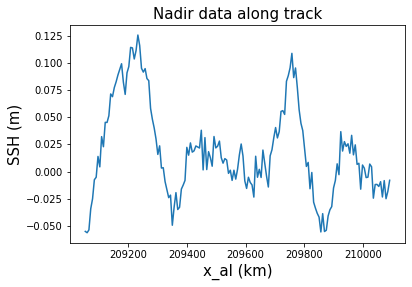

In [5]:
### SSH(m) vs Nadir along track (x_al) for Nadir data
plt.figure()
plt.plot(x_al,ssh_nadir)
plt.ylabel('SSH (m)',fontsize=15)
plt.xlabel('x_al (km)',fontsize=15)
plt.title('Nadir data along track', fontsize=15)
plt.show()

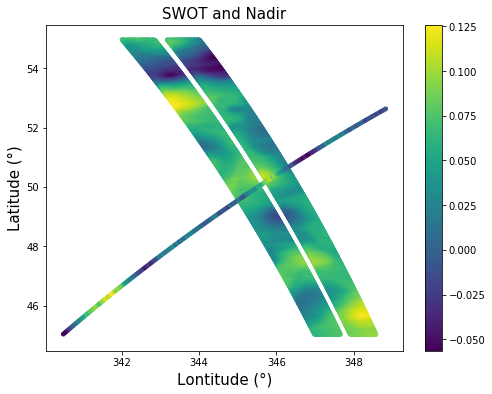

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(lon_swotpass, lat_swotpass,c=ssh_swotpass,s=15)
plt.scatter(lon_nadirpass,lat_nadirpass,c=ssh_nadir,s=15) 
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and Nadir',fontsize=15)
plt.colorbar()

# 2. Interpolation of SWOT on Nadir
First: select the swot swath

In [7]:
lon_swotcut = lon_swotpass[250:350]
lat_swotcut = lat_swotpass[250:350]
ssh_swotcut = ssh_swotpass[250:350]

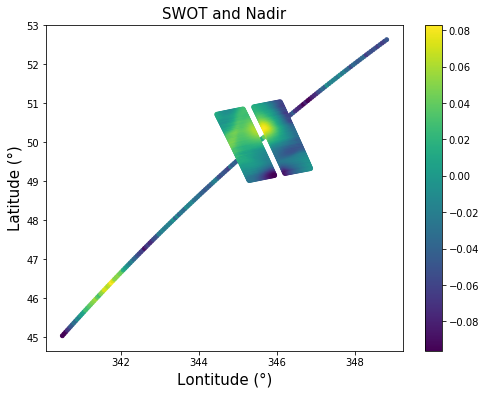

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(lon_nadirpass,lat_nadirpass,c=ssh_nadir,s=15) 
plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and Nadir',fontsize=15)
plt.colorbar() 

## Interpolation of SWOT on nadir

In [9]:
swot2nadir_interp = interp2d(lon_swotcut, lat_swotcut, ssh_swotcut)


C:\Users\ASUS\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=64,86 m=5200 fp=0.001106 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [10]:
swot2nadir = swot2nadir_interp(lon_nadirpass, lat_nadirpass)
print(swot2nadir.shape)
swot_on_nadir =np.diag(swot2nadir)

(169, 169)


In [11]:
#swot_on_nadir = swot_on_nadir[swot_on_nadir!=0]
#lon_nadirpass_cut = lon_nadirpass[swot_on_nadir!=0]
#lat_nadirpass_cut = lat_nadirpass[swot_on_nadir!=0]

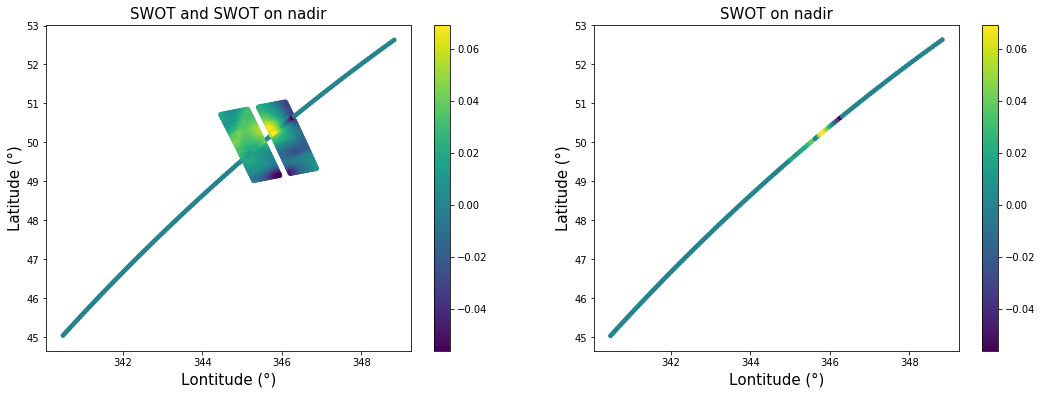

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.scatter(lon_nadirpass,lat_nadirpass,c=swot_on_nadir,s=15) 
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and SWOT on nadir',fontsize=15)
plt.colorbar()
plt.subplot(122)
plt.scatter(lon_nadirpass,lat_nadirpass,c=swot_on_nadir,s=15) 
#plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT on nadir',fontsize=15)
plt.colorbar()

In [13]:
#ls -l

In [14]:
### We can now start the interpolation on the new ssh_nadir

from function_nadirpoints_in_swotgrid import nadirpoints_in_swotgrid

ssh_nadir_cut= nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass, ssh_nadir, lon_swotcut, lat_swotcut)
swot_on_nadir_cut= nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass, swot_on_nadir, lon_swotcut, lat_swotcut)

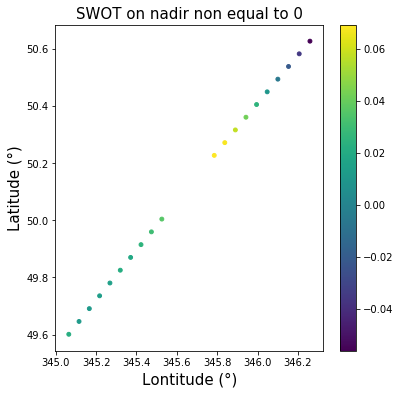

In [15]:
plt.figure(figsize=(6,6)) 
plt.scatter(lon_nadirpass,lat_nadirpass,c=swot_on_nadir_cut,s=15) 
#plt.scatter(lon_swotcut, lat_swotcut,c=ssh_swotcut,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT on nadir non equal to 0',fontsize=15)
plt.colorbar()

In [16]:
### We can now start the interpolation on the new ssh_nadir

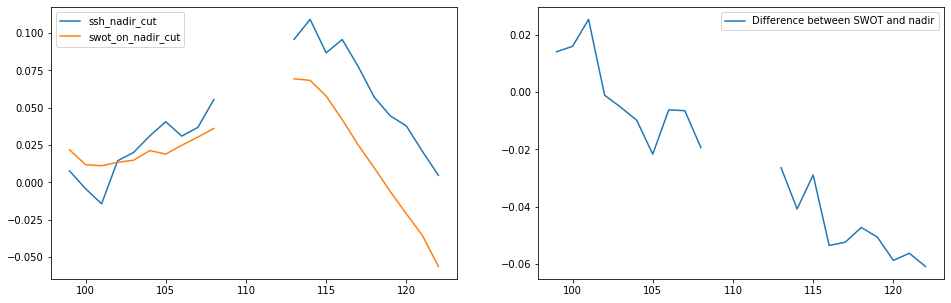

In [17]:
# Difference (C(h) as used in the Latex document) between the ssh (swot_on_nadir) and the ssh nadir
Difference = swot_on_nadir_cut-ssh_nadir_cut

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(ssh_nadir_cut,label='ssh_nadir_cut')
plt.plot(swot_on_nadir_cut,label='swot_on_nadir_cut')
plt.legend()
plt.subplot(122)
plt.plot(Difference,label='Difference between SWOT and nadir')
plt.legend()

# To interpolate error free SWOT onto Nadir

In [18]:
ssh_swotpass_truth_cut = ssh_swotpass_truth[250:350]
swottruth2nadir_interp = interp2d(lon_swotcut,lat_swotcut,ssh_swotpass_truth_cut)

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=72,77 m=5200 fp=0.000010 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


Text(0, 0.5, 'SSH (m)')

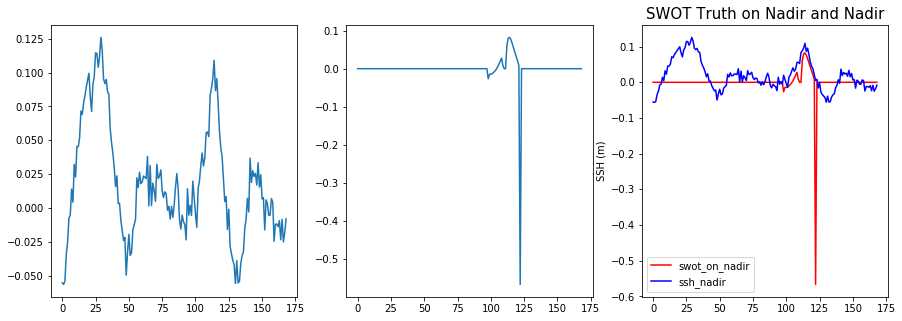

In [19]:
swottruth2nadir = swottruth2nadir_interp(lon_nadirpass,lat_nadirpass)
swottruth_on_nadir = np.diag(swottruth2nadir)
swottruth_on_nadir.shape # SWOT SSH on Nadir

# To plot
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(ssh_nadir)
plt.subplot(132)
plt.plot(swottruth_on_nadir)
plt.subplot(133)
plt.plot(swottruth_on_nadir,label='swot_on_nadir',color='r')
plt.plot(ssh_nadir,label='ssh_nadir',color='b')
plt.legend()
plt.title('SWOT Truth on Nadir and Nadir',fontsize=15)
plt.ylabel('SSH (m)')

In [20]:
#ls -l

Text(0, 0.5, 'SSH (m)')

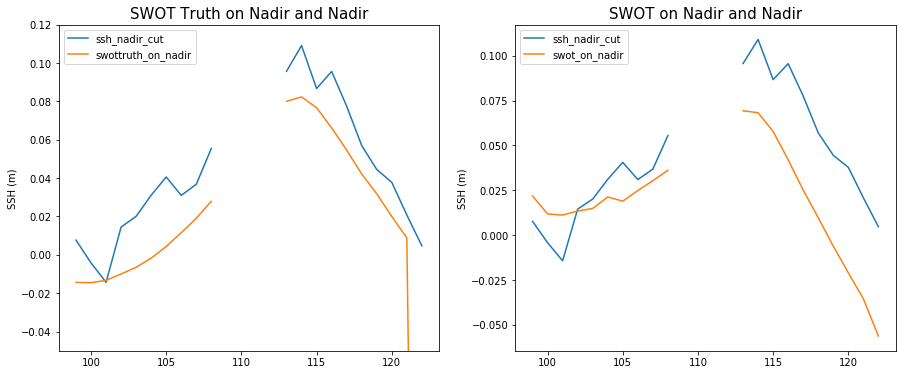

In [25]:
#ssh_nadir_cut = nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass, ssh_nadir, lon_swotcut, lat_swotcut)
swottruth_on_nadir_cut =  nadirpoints_in_swotgrid(lon_nadirpass, lat_nadirpass,swottruth_on_nadir, lon_swotcut, lat_swotcut)
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(ssh_nadir_cut,label='ssh_nadir_cut')
plt.plot(swottruth_on_nadir_cut,label='swottruth_on_nadir')
plt.legend()
plt.title('SWOT Truth on Nadir and Nadir',fontsize=15)
plt.ylabel('SSH (m)')
x = plt.gca()
x.set_ylim(-0.05,0.12)
plt.subplot(122)
plt.plot(ssh_nadir_cut,label='ssh_nadir_cut')
plt.plot(swot_on_nadir_cut,label='swot_on_nadir')
plt.legend()
plt.title('SWOT on Nadir and Nadir',fontsize=15)
plt.ylabel('SSH (m)')



#################################
# We can see below that the difference between swot_on_nadir and nadir in the first figure(right side of plot)
# is smaller than in the right figure
#### This is because the SWOT in the right figure has more errors than in the left figure







################################

## real error

Text(0, 0.5, 'SSH (m)')

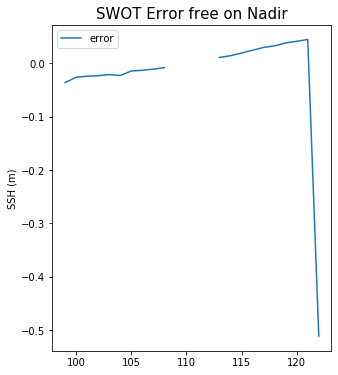

In [26]:
Error=swottruth_on_nadir_cut-swot_on_nadir_cut
plt.figure(figsize=(5,6))
plt.plot(Error,label='error')
plt.legend()
plt.title('SWOT Error free on Nadir',fontsize=15)
plt.ylabel('SSH (m)')

# Cost Fuction

# Creation of the function to minimize
create the function $DN=DN_1+DN_2$\
With $$DN_1=\frac{\gamma}{2}(C(h)-h_n)^2$$ 
and $$DN_2=\frac{1}{2}(h-h_s+f(\alpha,x_c,x_a))^2$$
So $$DN=\frac{\gamma}{2}(C(h)-h_n)^2+\frac{1}{2}(h-h_s+f(\alpha,x_c,x_a))^2$$
Where 
$h = h(x_c, x_a)$ is the sought SSH, defined on the SWOT grid;\
$h_n = h_n(x_n)$ is the nadir SSH, defined on the nadir line, which coordinate is written $x_n$;\
$C$ interpolates the SWOT field onto the nadir line. $C(h)$ is the SWOT data as it would be seen by the nadir altimeter. $C(h)$ and $h_n$ are of the same nature (pixel size and locations) so that their difference can be computed and meaningful;\
$h_s = h_s(x_c, x_a)$ is the SWOT data (with their errors);\
$\alpha = (\alpha_0, \ldots, \alpha_6)$;\
$f$ is the error model, that should include all errors, with KaRIn errors;\
$\gamma$ is a weight to be prescribed depending upon the relative amplitude of the errors in nadir and SWOT data (a big value gives more weight to nadir data if their errors are small in comparison with SWOT, what is not the case...)

In [23]:
#cost_function(ssh_swotpass, swot_on_nadir, ssh_nadir_cut)

def cost_function(ssh_swotpass, swot_on_nadir, ssh_nadir_cut):
    n_gap=10
    ssh_swotgrid0 = ssh_swotpass
    ssh_across = np.nanmean(ssh_swotgrid0,0)
    dimtime = np.shape(ssh_swotgrid0)[0]
    # Width of the swath
    dimnc = np.shape(ssh_swotgrid0)[1]
    if np.shape(ssh_across)[0]==dimnc:
        nn = np.shape(ssh_across)[0]
        a1=0
        b1=0 
        c1=0 
        e11=0
        e12=0 
        f11=0
        f12=0 
        h = 0
    if nn != 0:
        x_across = np.arange(nn)-int(nn/2)    
        x_across[x_across<0]=x_across[x_across<0]-n_gap/2+1 
        x_across[x_across>=0]=x_across[x_across>=0]+n_gap/2  
        if nn == np.shape(x_across)[0]:
            # Cost function
            def linreg3(params): # params[7]== sought ssh==h 
                return np.sum(swot_on_nadir-ssh_nadir_cut)**2 + np.sum( 1/2*( params[7]-ssh_across+(params[0]+params[1]*x_across + params[2]*x_across**2 +np.append(params[3]+params[4]*x_across[x_across<=0],params[5]+params[6]*x_across[x_across>0],axis=0) ) )**2 ) 
            # Minimization  
            params = np.array([a1,b1,c1,e11,e12,f11,f12,h])
            coefopt = so.minimize(linreg3, params, method = "Powell") 
            a1,b1,c1,e11,e12,f11,f12,h = coefopt['x'][0], coefopt['x'][1], coefopt['x'][2], coefopt['x'][3], coefopt['x'][4], coefopt['x'][5], coefopt['x'][6] , coefopt['x'][7]
    return a1,b1,c1,e11,e12,f11,f12,h
   

In [27]:
class ocean_altitude:    
    def CostFunction(self, params):
        """Compute cost function to minimize and find the better ssh. """
        cost=0.
        gamma=1
        ## Jb
        costb=np.sum( ( self.h-ssh_across+(params[0]+params[1]*self.x_across + params[2]*self.x_across**2 +np.append(params[3]+params[4]*self.x_across[x_across<=0],params[5]+params[6]*self.x_across[self.x_across>0],axis=0) ) )**2 ) 
        costo=np.sum( gamma/2(self.swot_on_nadir_cut-self.ssh_nadir_cut)**2)
        cost=costb+costo
        return cost
    
    def minim (self):
        """Compute optimal parameters by minimizing CostFunction. Return the final cost function value. """
        n_gap=10
        # Size of averaging box for regression coefficient (only works if meanafter == True)
        #boxsize = 500 
        # Lenght of the swath
        dimtime = np.shape(ssh_swotgrid0)[0]
        # Width of the swath
        dimnc = np.shape(ssh_swotgrid0)[1]
    
        ssh_detrended0 = np.zeros_like(ssh_swotgrid0)
        ssh_detrended0[:,:] = ssh_swotgrid0[:,:]
    
        # Initialization of the regression coefficients
        a1=0
        b1=0 
        c1=0 
        e11=0
        e12=0 
        f11=0
        f12=0 
        
        ssh_across = np.nanmean(ssh_swotgrid0,0) 
        if np.shape(ssh_across)[0]==dimnc:  
            nn = np.shape(ssh_across)[0] 
            if nn != 0: 
                x_across = np.arange(nn)-int(nn/2)    
                x_across[x_across<0]=x_across[x_across<0]-n_gap/2+1 
                x_across[x_across>=0]=x_across[x_across>=0]+n_gap/2   

                if nn == np.shape(x_across)[0]: 
                      
                    # Perform minimization  
                    params = np.array([a1,b1,c1,e11,e12,f11,f12,h])
                    coefopt = so.minimize(self.CostFunction, params, method = "Powell") 
                    a1,b1,c1,e11,e12,f11,f12,h = coefopt['x'][0], coefopt['x'][1], coefopt['x'][2], coefopt['x'][3], coefopt['x'][4], coefopt['x'][5], coefopt['x'][6],  coefopt['x'][7]
        return h

     